: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.47it/s]
C:\Users\Jayant\Documents\segPipieline\pytorch-deeplab-xception-master\utils\metrics.py:14: RuntimeWarning: invalid value encountered in true_divide
  Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
C:\Users\Jayant\Documents\segPipieline\pytorch-deeplab-xception-master\utils\metrics.py:21: RuntimeWarning: invalid value encountered in true_divide
  np.diag(self.confusion_matrix))
C:\Users\Jayant\Documents\segPipieline\pytorch-deeplab-xception-master\utils\metrics.py:29: RuntimeWarning: invalid value encountered in true_divide
  np.diag(self.confusion_matrix))
:   0%|                                                                                                                                                                                   | 0/18 [00:00<

Validation:
[Epoch: 1, numImages:    18]
Acc:0.8492360844594581, Acc_class:0.7100926005657038, mIoU:0.5465049026274418, fwIoU: 0.7518508634833698
Classwise_IoU:
[0.85145057        nan 0.68521793 0.5467664  0.52688152 0.29378265
 0.45266752 0.4167785  0.59849413]
Loss: 0.000


: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.79it/s]


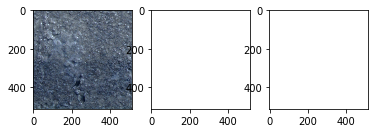

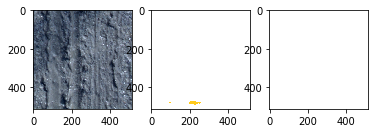

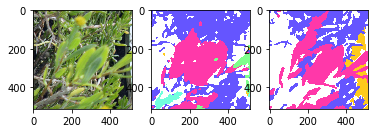

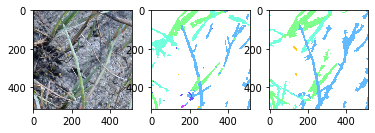

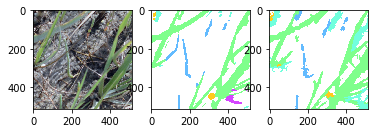

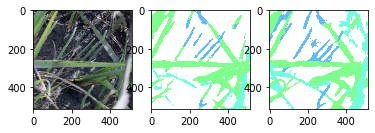

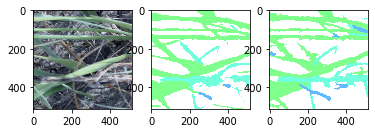

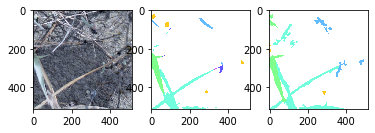

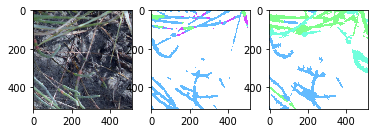

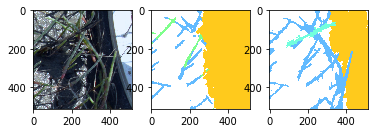

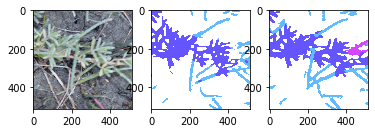

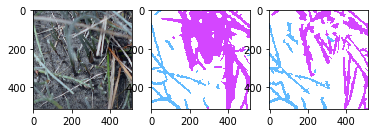

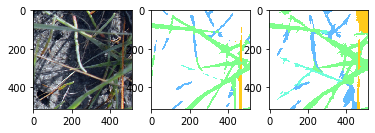

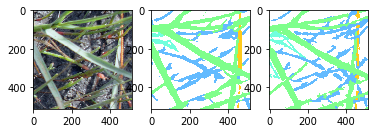

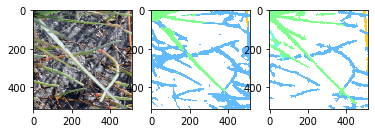

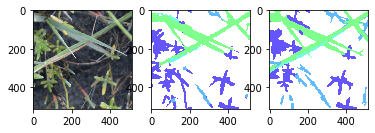

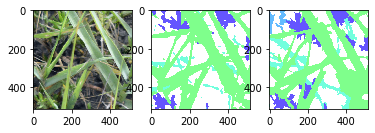

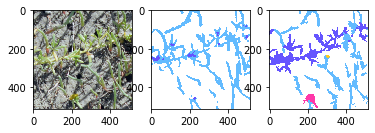

In [2]:
import argparse
import os
import numpy as np
from tqdm import tqdm

from mypath import Path
from dataloaders import make_data_loader
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator
from dataloaders.datasets import saltmarsh
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils
from torchvision.utils import make_grid
from dataloaders.utils import decode_seg_map_sequence

class Tester(object):
    def __init__(self,args):
        
        self.args=args
        
        # Define Dataloader
        kwargs = {'num_workers': args.workers, 'pin_memory': True}
        self.train_loader, self.val_loader, self.test_loader, self.nclass = make_data_loader(args, **kwargs)

        # Define network
        model = DeepLab(num_classes=self.nclass,
                        backbone=args.backbone,
                        output_stride=args.out_stride,
                        sync_bn=args.sync_bn,
                        freeze_bn=args.freeze_bn)
        self.address='run\marsh\deeplab-resnet\model_best.pth.tar'#change model address here + model name in args..

        checkpoint=torch.load(self.address)
        model.load_state_dict(checkpoint['state_dict'])
        self.model=model
        
        model.cuda()
        
        # Define Evaluator
        self.evaluator = Evaluator(self.nclass)
        
#         # Using cuda
#         if args.cuda:
#             self.model = torch.nn.DataParallel(self.model, device_ids=self.args.gpu_ids)
#             patch_replication_callback(self.model)
#             self.model = self.model.cuda()

    def validation(self):
        self.model.eval()
        self.evaluator.reset()
        tbar = tqdm(self.val_loader, desc='\r')
        test_loss = 0.0
        for i, sample in enumerate(tbar):
            image, target = sample['image'], sample['label']
            if self.args.cuda:
                image, target = image.cuda(), target.cuda()
            with torch.no_grad():
                output = self.model(image)
            pred = output.data.cpu().numpy()
            target = target.cpu().numpy()
            pred = np.argmax(pred, axis=1)
            # Add batch sample into evaluator
            self.evaluator.add_batch(target, pred)
            

        # Fast test during the training
        Acc = self.evaluator.Pixel_Accuracy()
        Acc_class = self.evaluator.Pixel_Accuracy_Class()
        mIoU,IoU = self.evaluator.Mean_Intersection_over_Union()
        FWIoU = self.evaluator.Frequency_Weighted_Intersection_over_Union()
        print('Validation:')
        print('[Epoch: %d, numImages: %5d]' % (1, i * self.args.batch_size + image.data.shape[0]))
        print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
        print("Classwise_IoU:")
        print(IoU)
        print('Loss: %.3f' % test_loss)
        #print(self.evaluator.confusion_matrix)
    def predict_masks(self):
        self.model.eval()
        self.evaluator.reset()
        tbar = tqdm(self.val_loader, desc='\r')
        test_loss = 0.0
        j=0
        for i, sample in enumerate(tbar):
            image, target = sample['image'], sample['label']
            if self.args.cuda:
                image, target = image.cuda(), target.cuda()
            with torch.no_grad():
                output = self.model(image)
            image=image[:3].clone().cpu().data
            pred_mask= torch.max(output[:3], 1)[1].detach().cpu()
            mask=torch.squeeze(target[:3], 1).detach().cpu()
            grid_image = make_grid(image[:3].clone().cpu().data, 3, normalize=True).permute(1, 2, 0)
            grid_pred = make_grid(decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy(),
                                                       dataset=self.args.dataset), 3, normalize=False, range=(0, 255)).permute(1, 2, 0)
            grid_mask = make_grid(decode_seg_map_sequence(torch.squeeze(target[:3], 1).detach().cpu().numpy(),
                                                       dataset=self.args.dataset), 3, normalize=False, range=(0, 255)).permute(1, 2, 0)
#             #plot of images
#             plt.figure()
#             plt.subplot(1,3,1)
#             plt.imshow(torchvision.utils.make_grid(image, nrow=5).permute(1, 2, 0), 'gray', interpolation='none')
#             plt.subplot(1,3,2)
#             plt.imshow(torchvision.utils.make_grid(pred_mask, nrow=5).permute(1, 2, 0), 'gray', interpolation='none')
#             plt.subplot(1,3,3)
#             plt.imshow(torchvision.utils.make_grid(mask, nrow=5).permute(1, 2, 0), 'gray', interpolation='none')
#             plt.show()

            #plot of images
            plt.figure()
            plt.subplot(1,3,1)
            plt.imshow(grid_image, 'gray', interpolation='none')
            plt.subplot(1,3,2)
            plt.imshow(grid_pred, 'gray', interpolation='none')
            plt.subplot(1,3,3)
            plt.imshow(grid_mask, 'gray', interpolation='none')
            #plt.show()
            plt.savefig('Data/results/'+str(j)+".png",bbox_inches='tight')
            j=j+1


def main():
    parser = argparse.ArgumentParser(description="PyTorch DeeplabV3Plus Training")
    parser.add_argument('--backbone', type=str, default='resnet',
                        choices=['resnet', 'xception', 'drn', 'mobilenet'],
                        help='backbone name (default: resnet)')
    parser.add_argument('--out-stride', type=int, default=16,
                        help='network output stride (default: 8)')
    parser.add_argument('--dataset', type=str, default='marsh',
                        choices=['pascal', 'coco', 'cityscapes','marsh'],
                        help='dataset name (default: pascal)')
    parser.add_argument('--use-sbd', action='store_true', default=True,
                        help='whether to use SBD dataset (default: True)')
    parser.add_argument('--workers', type=int, default=4,
                        metavar='N', help='dataloader threads')
    parser.add_argument('--base-size', type=int, default=513,
                        help='base image size')
    parser.add_argument('--crop-size', type=int, default=513,
                        help='crop image size')
    parser.add_argument('--sync-bn', type=bool, default=None,
                        help='whether to use sync bn (default: auto)')
    parser.add_argument('--freeze-bn', type=bool, default=False,
                        help='whether to freeze bn parameters (default: False)')
    parser.add_argument('--loss-type', type=str, default='ce',
                        choices=['ce', 'focal'],
                        help='loss func type (default: ce)')
    # training hyper params
    parser.add_argument('--epochs', type=int, default=None, metavar='N',
                        help='number of epochs to train (default: auto)')
    parser.add_argument('--start_epoch', type=int, default=0,
                        metavar='N', help='start epochs (default:0)')
    parser.add_argument('--batch-size', type=int, default=1,
                        metavar='N', help='input batch size for \
                                training (default: auto)')
    parser.add_argument('--test-batch-size', type=int, default=None,
                        metavar='N', help='input batch size for \
                                testing (default: auto)')
    parser.add_argument('--use-balanced-weights', action='store_true', default=False,
                        help='whether to use balanced weights (default: False)')
    # optimizer params
    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (default: auto)')
    parser.add_argument('--lr-scheduler', type=str, default='poly',
                        choices=['poly', 'step', 'cos'],
                        help='lr scheduler mode: (default: poly)')
    parser.add_argument('--momentum', type=float, default=0.9,
                        metavar='M', help='momentum (default: 0.9)')
    parser.add_argument('--weight-decay', type=float, default=5e-4,
                        metavar='M', help='w-decay (default: 5e-4)')
    parser.add_argument('--nesterov', action='store_true', default=False,
                        help='whether use nesterov (default: False)')
    # cuda, seed and logging
    parser.add_argument('--no-cuda', action='store_true', default=
                        False, help='disables CUDA training')
    parser.add_argument('--gpu-ids', type=str, default='0',
                        help='use which gpu to train, must be a \
                        comma-separated list of integers only (default=0)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    # checking point
    parser.add_argument('--resume', type=str, default=None,
                        help='put the path to resuming file if needed')
    parser.add_argument('--checkname', type=str, default=None,
                        help='set the checkpoint name')
    # finetuning pre-trained models
    parser.add_argument('--ft', action='store_true', default=False,
                        help='finetuning on a different dataset')
    # evaluation option
    parser.add_argument('--eval-interval', type=int, default=1,
                        help='evaluuation interval (default: 1)')
    parser.add_argument('--no-val', action='store_true', default=False,
                        help='skip validation during training')

    args = parser.parse_args(args=[])
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    tester = Tester(args)
    tester.validation()
    tester.predict_masks()


if __name__ == "__main__":
    main()